In [1]:
from src.data.data_utility import get_sliding_windows_from_sequence
import matplotlib.pyplot as plt

from src.models.deep_learning.TransformerAutoEncoder import TransformerTemporalAutoencoder

# src/features/temporal_autoencoder_features.py
"""
Temporal autoencoder features adapted from SHM damage localization
for structural break detection in time series
"""

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.decomposition import PCA
from scipy import signal, stats
from typing import Dict, Tuple

from tqdm import tqdm
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score

In [2]:
from src.data.dataLoader import StructuralBreakDataLoader
from src.models.deep_learning.CNN_autoencoder import CNNTemporalAutoencoder

In [3]:
# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"Memory Allocated: {torch.cuda.memory_allocated(0) / 1024 ** 2:.2f} MB")

Using device: cuda
Memory Allocated: 0.00 MB


In [4]:
data_handler = StructuralBreakDataLoader()
data_handler.load_data(use_crunch=False)
train_dict, test_dict = data_handler.create_train_val_split(val_ratio=0.2, data_ratio=0.02)

INFO:src.data.dataLoader:Data loaded successfully from local files


In [5]:
from src.data.dataLoader import TimeSeriesData
from typing import Optional


def plot_timeseries_dataclass(
    ts: TimeSeriesData,
    prediction: Optional[float] = None,
    save_path: Optional[str] = None
):
    """
    Plot a time series with highlighted periods and break point using TimeSeriesData.

    Args:
        ts: TimeSeriesData instance containing series and metadata
        prediction: Model prediction score, if available
        save_path: Path to save the plot image, or None to display
    """
    # Create masks based on boundary_point
    period_0_mask = ts.time_points < ts.boundary_point
    period_1_mask = ts.time_points >= ts.boundary_point

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [3, 1]})

    # Main time series plot
    ax1.plot(
        ts.time_points[period_0_mask],
        ts.values[period_0_mask],
        'b-', label='Period 0', alpha=0.7
    )
    ax1.plot(
        ts.time_points[period_1_mask],
        ts.values[period_1_mask],
        'r-', label='Period 1', alpha=0.7
    )

    # Boundary marker
    ax1.axvline(x=ts.boundary_point, color='green', linestyle='--', label='Boundary', alpha=0.5)

    # Title with labels
    title = f"Series {ts.series_id}"
    if ts.has_break is not None:
        title += f" | True Label: {'Break' if ts.has_break else 'No Break'}"
    if prediction is not None:
        title += f" | Prediction: {prediction:.3f}"

    ax1.set_title(title)
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Value')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Period indicator subplot
    periods = np.where(period_1_mask, 1, 0)
    ax2.fill_between(
        ts.time_points, 0, periods, alpha=0.5, step='post'
    )
    ax2.set_ylabel('Period')
    ax2.set_xlabel('Time')
    ax2.set_ylim(-0.1, 1.1)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    else:
        plt.show()

    plt.close()

In [6]:
class BreakDetectionAutoencoderExtractor:
    """
    Modified autoencoder feature extractor specifically for break detection
    Implements Approach 2: Train on partial regime 1, test on both regimes
    """

    def __init__(self, sequence_length: int = 64, train_ratio: float = 0.7):
        self.sequence_length = sequence_length
        self.train_ratio = train_ratio
        self.autoencoder = None
        self.scale_factor = 1.0

    def train_autoencoder_on_regime(self, regime_data: np.ndarray,
                                    bottleneck_dim: int = 16,
                                    num_epochs: int = 15) -> Dict:
        """Train autoencoder on a specific regime"""
        # Create sliding windows
        sequences = get_sliding_windows_from_sequence(regime_data, self.sequence_length)

        # Scale to prevent numerical issues
        scale_factor = np.std(sequences)
        if scale_factor > 0:
            sequences_scaled = sequences / scale_factor
        else:
            sequences_scaled = sequences
            scale_factor = 1.0

        self.scale_factor = scale_factor

        # Create autoencoder
        input_dim = sequences.shape[1]
        self.autoencoder = CNNTemporalAutoencoder(input_dim, bottleneck_dim).to(device)

        # Training setup
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.autoencoder.parameters(), lr=0.01)

        # Convert to tensors
        X_tensor = torch.FloatTensor(sequences_scaled).to(device)

        # Training loop
        self.autoencoder.train()
        losses = []
        
        N_train = X_tensor.shape[0]
        batch_size = 32

        for epoch in range(num_epochs):
            perm = torch.randperm(N_train, device=device)
            for i in range(0, N_train, batch_size):
                batch_idx = perm[i:i+batch_size]
                batch = X_tensor[batch_idx]
                
                optimizer.zero_grad()
                reconstructed = self.autoencoder(batch)
                loss = criterion(reconstructed, batch)
                loss.backward()
                optimizer.step()
                losses.append(loss.item())

        return {
            'final_loss': losses[-1],
            'n_sequences': len(sequences)
        }

    def get_reconstruction_errors(self, time_series: np.ndarray) -> np.ndarray:
        """Get reconstruction errors for a time series"""
        if self.autoencoder is None:
            raise ValueError("Autoencoder not trained yet")

        sequences = get_sliding_windows_from_sequence(time_series, self.sequence_length)
        sequences_scaled = sequences / self.scale_factor

        self.autoencoder.eval()
        with torch.no_grad():
            X_tensor = torch.FloatTensor(sequences_scaled).to(device)
            reconstructed = self.autoencoder(X_tensor).cpu().numpy()

        # MSE per sequence
        reconstruction_errors = np.mean((sequences_scaled - reconstructed) ** 2, axis=1)
        return reconstruction_errors

    def extract_break_detection_features(self, time_series: np.ndarray,
                                         break_point: int) -> Dict[str, float]:
        """
        Extract features using Approach 2: Train on partial regime 1, test on both regimes
        """
        features = {}

        # Split at known break point
        regime1 = time_series[:break_point]
        regime2 = time_series[break_point:]

        # Train on partial regime 1 (first 70%)
        train_size = int(self.train_ratio * len(regime1))
        train_data = regime1[:train_size]

        # Train autoencoder
        self.train_autoencoder_on_regime(train_data, bottleneck_dim=16, num_epochs=15)

        # Get reconstruction errors on different parts
        # 1. Holdout part of regime 1
        regime1_holdout = regime1[train_size:]
        errors_regime1_holdout = self.get_reconstruction_errors(regime1_holdout)

        # 2. Full regime 2
        errors_regime2 = self.get_reconstruction_errors(regime2)

        # 3. Transition region (optional but useful)
        transition_size = min(self.sequence_length * 2, len(regime1) // 4, len(regime2) // 4)
        transition_data = time_series[break_point - transition_size:break_point + transition_size]
        errors_transition = self.get_reconstruction_errors(transition_data)

        # Core features: Error ratios
        mean_error_r1 = np.mean(errors_regime1_holdout)
        mean_error_r2 = np.mean(errors_regime2)

        features['error_ratio_r2_r1'] = mean_error_r2 / (mean_error_r1 + 1e-8)
        features['error_diff_r2_r1'] = mean_error_r2 - mean_error_r1

        # Variance ratios
        features['error_var_ratio'] = np.var(errors_regime2) / (np.var(errors_regime1_holdout) + 1e-8)

        # Statistical test for distribution difference
        if len(errors_regime1_holdout) > 1 and len(errors_regime2) > 1:
            _, p_value = stats.mannwhitneyu(errors_regime1_holdout, errors_regime2)
            features['error_distribution_pvalue'] = p_value

            # Kolmogorov-Smirnov test
            _, ks_pvalue = stats.ks_2samp(errors_regime1_holdout, errors_regime2)
            features['error_ks_pvalue'] = ks_pvalue
        else:
            features['error_distribution_pvalue'] = 1.0
            features['error_ks_pvalue'] = 1.0

        # Transition features
        features['transition_error_spike'] = np.mean(errors_transition) / (mean_error_r1 + 1e-8)
        features['transition_error_max'] = np.max(errors_transition) / (mean_error_r1 + 1e-8)

        # Error percentiles
        features['error_r2_75th_percentile'] = np.percentile(errors_regime2, 75)
        features['error_r1_75th_percentile'] = np.percentile(errors_regime1_holdout, 75)
        features['error_percentile_ratio'] = features['error_r2_75th_percentile'] / (
                features['error_r1_75th_percentile'] + 1e-8)

        # Error dynamics
        if len(errors_regime2) > 2:
            # Trend in regime 2 errors
            x = np.arange(len(errors_regime2))
            trend_r2 = np.polyfit(x, errors_regime2, 1)[0]
            features['error_trend_r2'] = trend_r2
        else:
            features['error_trend_r2'] = 0.0

        # Training loss as a feature
        features['ae_training_loss'] = self.autoencoder.training_dict['final_loss'] \
            if hasattr(self.autoencoder, 'training_dict') else 0.0

        return features

    def _get_default_features(self) -> Dict[str, float]:
        """Return default features when extraction fails"""
        return {
            'error_ratio_r2_r1': 1.0,
            'error_diff_r2_r1': 0.0,
            'error_var_ratio': 1.0,
            'error_distribution_pvalue': 1.0,
            'error_ks_pvalue': 1.0,
            'transition_error_spike': 1.0,
            'transition_error_max': 1.0,
            'error_r2_75th_percentile': 0.0,
            'error_r1_75th_percentile': 0.0,
            'error_percentile_ratio': 1.0,
            'error_trend_r2': 0.0,
            'ae_training_loss': 0.0
        }

In [116]:
def extract_features_for_dataset(data_dict: Dict, sample_size: int = None) -> Tuple[np.ndarray, np.ndarray]:
    """
    Extract autoencoder features for all time series in the dataset
    """
    extractor = BreakDetectionAutoencoderExtractor(sequence_length=64)

    features_list = []
    labels = []

    # Get keys
    keys = list(data_dict.keys())
    if sample_size is not None:
        keys = keys[:sample_size]

    print(f"Extracting features for {len(keys)} time series...")

    for key in tqdm(keys):
        data = data_dict[key]

        # Get full time series and break point
        if hasattr(data, 'period_0_values') and hasattr(data, 'period_1_values'):
            time_series = np.concatenate([data.period_0_values, data.period_1_values])
            break_point = len(data.period_0_values)
            label = int(data.has_break)
        else:
            continue

        # Extract features
        features = extractor.extract_break_detection_features(time_series, break_point)
        features_list.append(list(features.values()))
        labels.append(label)

    return np.array(features_list), np.array(labels)


extractor = BreakDetectionAutoencoderExtractor(sequence_length=64)
 
# Extract features for train and test sets
print("Extracting training features...")
X_train, y_train = extract_features_for_dataset(train_dict)

print("Extracting test features...")
X_test, y_test = extract_features_for_dataset(test_dict)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Class distribution - Train: {np.bincount(y_train)}")
print(f"Class distribution - Test: {np.bincount(y_test)}")

# Train XGBoost model
print("\nTraining XGBoost model...")

# Create and train XGBoost classifier
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    objective='binary:logistic',
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

y_pred_proba_train = xgb_model.predict_proba(X_train)[:, 1]
y_pred_proba_test = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate model
print("\n=== Training Set Performance ===")
print(classification_report(y_train, y_pred_train))
print(f"ROC AUC: {roc_auc_score(y_train, y_pred_proba_train):.4f}")

print("\n=== Test Set Performance ===")
print(classification_report(y_test, y_pred_test))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_test):.4f}")

# Feature importance
feature_names = list(extractor._get_default_features().keys())
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n=== Top 10 Most Important Features ===")
print(feature_importance.head(10))

Extracting training features...
Extracting features for 160 time series...


100%|██████████| 160/160 [07:23<00:00,  2.77s/it]


Extracting test features...
Extracting features for 39 time series...


100%|██████████| 39/39 [01:48<00:00,  2.78s/it]


Training set shape: (160, 12)
Test set shape: (39, 12)
Class distribution - Train: [113  47]
Class distribution - Test: [28 11]

Training XGBoost model...

=== Training Set Performance ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       113
           1       1.00      1.00      1.00        47

    accuracy                           1.00       160
   macro avg       1.00      1.00      1.00       160
weighted avg       1.00      1.00      1.00       160

ROC AUC: 1.0000

=== Test Set Performance ===
              precision    recall  f1-score   support

           0       0.74      0.82      0.78        28
           1       0.38      0.27      0.32        11

    accuracy                           0.67        39
   macro avg       0.56      0.55      0.55        39
weighted avg       0.64      0.67      0.65        39

ROC AUC: 0.5519

=== Top 10 Most Important Features ===
                      feature  importance
1           

In [7]:
def plot_example_with_errors(data_dict, idx, extractor):
    """Plot a time series with its reconstruction errors"""
    key = list(data_dict.keys())[idx]
    data = data_dict[key]
    
    time_series = np.concatenate([data.period_0_values, data.period_1_values])
    break_point = len(data.period_0_values)
    label = data.has_break
    
    # Get features
    features = extractor.extract_break_detection_features(time_series, break_point)
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # Time series with colored regions
    train_size = int(0.7 * break_point)
    
    # Plot time series with different colors for regions
    ax1.plot(np.arange(train_size), time_series[:train_size], 
             color='blue', label='Regime 1 (train)', linewidth=2)
    ax1.plot(np.arange(train_size, break_point), time_series[train_size:break_point], 
             color='green', label='Regime 1 (test)', linewidth=2)
    ax1.plot(np.arange(break_point, len(time_series)), time_series[break_point:], 
             color='orange', label='Regime 2 (test)', linewidth=2)
    ax1.axvline(break_point, color='red', linestyle='--', label='Break Point', linewidth=2)
    ax1.axvline(train_size, color='gray', linestyle=':', label='Train/Test Split', alpha=0.7)
    ax1.set_title(f'Time Series (Has Break: {label})')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Value')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Reconstruction errors
    regime1 = time_series[:break_point]
    regime2 = time_series[break_point:]
    
    # First, we need to retrain the autoencoder to match what was done in feature extraction
    extractor_viz = BreakDetectionAutoencoderExtractor(sequence_length=50)
    train_data = regime1[:train_size]
    extractor_viz.train_autoencoder_on_regime(train_data, bottleneck_dim=10, num_epochs=30)
    
    # Get reconstruction errors for each region
    errors_r1_train = extractor_viz.get_reconstruction_errors(regime1[:train_size])
    errors_r1_test = extractor_viz.get_reconstruction_errors(regime1[train_size:])
    errors_r2 = extractor_viz.get_reconstruction_errors(regime2)
    
    # Calculate positions for plotting errors
    # Note: errors are computed on sliding windows, so fewer points than original series
    step_size = max(1, int(50 * 0.5))  # 50% overlap
    
    # Approximate x positions for errors
    x_train = np.linspace(0, train_size-50, len(errors_r1_train))
    x_test_r1 = np.linspace(train_size, break_point-50, len(errors_r1_test))
    x_test_r2 = np.linspace(break_point, len(time_series)-50, len(errors_r2))
    
    # Plot reconstruction errors
    ax2.plot(x_train, errors_r1_train, 'o-', color='blue', 
             label='Regime 1 (train)', alpha=0.7, markersize=4)
    ax2.plot(x_test_r1, errors_r1_test, 's-', color='green', 
             label='Regime 1 (test)', alpha=0.7, markersize=4)
    ax2.plot(x_test_r2, errors_r2, '^-', color='orange', 
             label='Regime 2 (test)', alpha=0.7, markersize=4)
    
    # Add vertical lines
    ax2.axvline(break_point, color='red', linestyle='--', linewidth=2, alpha=0.7)
    ax2.axvline(train_size, color='gray', linestyle=':', alpha=0.7)
    
    # Add horizontal line for mean error of regime 1 test as reference
    mean_r1_test = np.mean(errors_r1_test)
    ax2.axhline(mean_r1_test, color='green', linestyle=':', alpha=0.5, 
                label=f'Mean R1 test error: {mean_r1_test:.4f}')
    
    ax2.set_title(f"Reconstruction Errors (Ratio R2/R1: {features['error_ratio_r2_r1']:.3f}, "
                  f"p-value: {features['error_distribution_pvalue']:.4f})")
    ax2.set_xlabel('Time')
    ax2.set_ylabel('MSE')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [9]:
# Plot a few examples
print("\n=== Example Time Series ===")
for i in range(3):
    plot_example_with_errors(test_dict, i, extractor)


=== Example Time Series ===


NameError: name 'extractor' is not defined

In [8]:
train_dict.keys()

dict_keys([2093, 2543, 8455, 875, 2146, 123, 8093, 6771, 5903, 1026, 1143, 3570, 4209, 1486, 9083, 8336, 2114, 1051, 1609, 5895, 42, 9246, 3083, 4470, 8245, 1797, 7818, 7849, 4888, 3565, 1211, 7288, 1776, 6752, 142, 9306, 6195, 8763, 8137, 4425, 4505, 2723, 9487, 5346, 1989, 1644, 8572, 3302, 8649, 370, 1442, 3717, 7977, 2051, 9023, 1890, 9894, 453, 8477, 5947, 3323, 3407, 7190, 7801, 2033, 2694, 4043, 1420, 5836, 9765, 3944, 629, 6803, 7045, 2286, 9477, 5944, 4232, 9778, 4840, 4036, 7400, 6454, 3213, 1919, 9886, 9240, 3661, 6712, 5759, 4453, 5268, 1860, 8783, 2011, 4395, 7365, 7420, 9276, 4639, 4233, 1632, 9444, 5382, 9473, 2025, 1072, 9190, 138, 9953, 6232, 3101, 9196, 7047, 5522, 2572, 3652, 4162, 3592, 1955, 3415, 56, 7259, 6011, 8403, 806, 5978, 7730, 3807, 3442, 8685, 4869, 44, 3051, 5950, 7538, 4468, 6732, 5942, 5467, 7776, 2200, 2070, 7237, 3686, 2227, 3167, 8828, 4582, 48, 4890, 3994, 6657, 7208, 7711, 4079, 5981, 9788, 9509, 5053])

In [169]:
# 1) Select one series from train/test
train_key = next(iter(train_dict))
train_data = train_dict[2093]

# split at the break:
bp_train = int(len(train_data.period_0_values) * 0.7)

test_data = np.concatenate((train_data.period_0_values[bp_train:], train_data.period_1_values))

# 2) Prepare sliding windows
seq_len = 64
X_train_w = get_sliding_windows_from_sequence(train_data.period_0_values[:bp_train], seq_len)
X_test_w = get_sliding_windows_from_sequence(test_data, seq_len)

# 3) Scale by train std
scale = np.std(X_train_w) + 1e-8
X_train_s = X_train_w / scale
X_test_s  = X_test_w / scale

# 4) To torch
X_train = torch.from_numpy(X_train_s).float().to(device)
X_test  = torch.from_numpy(X_test_s).float().to(device)

# 5) Build model, loss, optimizer
input_dim      = 64
bottleneck_dim = 16
model          = CNNTemporalAutoencoder(input_dim, bottleneck_dim).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)

# 6) Training loop with test evaluation
num_epochs = 500
train_losses = []
test_losses  = []

for epoch in range(1, num_epochs + 1):
    # — train step —
    model.train()
    optimizer.zero_grad()
    recon_train = model(X_train)
    loss_train  = criterion(recon_train, X_train)
    loss_train.backward()
    optimizer.step()
    
    # — eval on test set —
    model.eval()
    with torch.no_grad():
        recon_test = model(X_test)
        loss_test  = criterion(recon_test, X_test)
    
    # record & print
    tl = loss_train.item()
    vl = loss_test.item()
    if epoch > 10:
        train_losses.append(tl)
        test_losses.append(vl)
    print(f"Epoch {epoch:02d} — Train Loss: {tl:.6f}, Test Loss: {vl:.6f}")

Epoch 01 — Train Loss: 3.770860, Test Loss: 1.038898
Epoch 02 — Train Loss: 3.050828, Test Loss: 1.046155
Epoch 03 — Train Loss: 1.469299, Test Loss: 1.051852
Epoch 04 — Train Loss: 1.217257, Test Loss: 1.094159
Epoch 05 — Train Loss: 1.183987, Test Loss: 1.159353
Epoch 06 — Train Loss: 1.141066, Test Loss: 1.197678
Epoch 07 — Train Loss: 1.106474, Test Loss: 1.192283
Epoch 08 — Train Loss: 1.083532, Test Loss: 1.160147
Epoch 09 — Train Loss: 1.063512, Test Loss: 1.125129
Epoch 10 — Train Loss: 1.048526, Test Loss: 1.101971
Epoch 11 — Train Loss: 1.040483, Test Loss: 1.090129
Epoch 12 — Train Loss: 1.036153, Test Loss: 1.081955
Epoch 13 — Train Loss: 1.031524, Test Loss: 1.073880
Epoch 14 — Train Loss: 1.025120, Test Loss: 1.067077
Epoch 15 — Train Loss: 1.018734, Test Loss: 1.062983
Epoch 16 — Train Loss: 1.014458, Test Loss: 1.061052
Epoch 17 — Train Loss: 1.012864, Test Loss: 1.059370
Epoch 18 — Train Loss: 1.012877, Test Loss: 1.056422
Epoch 19 — Train Loss: 1.012839, Test Loss: 1.

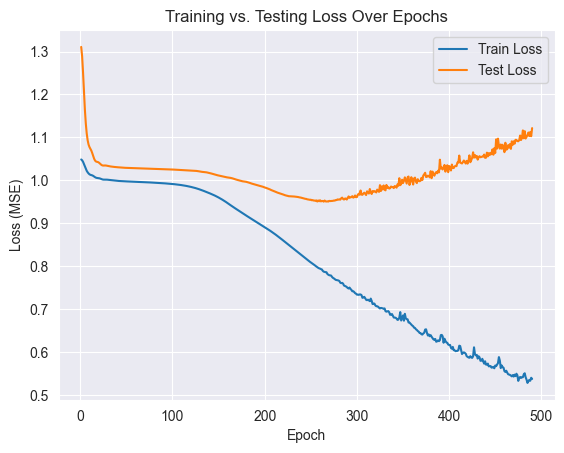

In [13]:
epochs = range(1, len(train_losses) + 1)
plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses,  label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training vs. Testing Loss Over Epochs')
plt.show()

In [19]:
# 1) Select one series from train/test
train_key = next(iter(train_dict))
train_data = train_dict[7776]

# split at the break:
bp_train = int(len(train_data.period_0_values) * 0.7)

test_data = np.concatenate((train_data.period_0_values[bp_train:], train_data.period_1_values))

# 2) Prepare sliding windows
seq_len = 128
X_train_w = get_sliding_windows_from_sequence(train_data.period_0_values[:bp_train], seq_len)
X_test_w = get_sliding_windows_from_sequence(test_data, seq_len)

# 3) Scale by train std
scale = np.std(X_train_w) + 1e-8
X_train_s = X_train_w / scale
X_test_s  = X_test_w / scale

# 4) To torch
# 1) Convert once, up front, to one big GPU tensor
X_train = torch.from_numpy(X_train_s).float().to(device)  # shape [N_train, seq_len]
X_test  = torch.from_numpy(X_test_s).float().to(device)   # shape [N_test,  seq_len]

# 2) Model, loss, optimizer
model     = CNNTemporalAutoencoder(seq_len, bottleneck_dim=32, dim_raise=4).to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=3e-4)

# 3) Manual batching without DataLoader
batch_size  = 32
num_epochs  = 20
train_losses = []
test_losses  = []
N_train     = X_train.size(0)
N_test      = X_test.size(0)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-5)

for epoch in range(1, num_epochs+1):
    model.train()
    # — shuffle GPU indices once per epoch —
    perm = torch.randperm(N_train, device=device)
    epoch_train_loss = 0.0

    # — iterate in-GPU batches —
    for i in range(0, N_train, batch_size):
        batch_idx = perm[i:i+batch_size]
        batch      = X_train[batch_idx]  # already on GPU
        
        optimizer.zero_grad()
        recon = model(batch)
        loss  = criterion(recon, batch)
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item() * batch.size(0)
    epoch_train_loss /= N_train
    
    scheduler.step()

    # — eval on test set similarly —
    model.eval()
    with torch.no_grad():
        epoch_test_loss = 0.0
        for i in range(0, N_test, batch_size):
            batch = X_test[i:i+batch_size]
            recon = model(batch)
            loss  = criterion(recon, batch)
            epoch_test_loss += loss.item() * batch.size(0)
        epoch_test_loss /= N_test

    train_losses.append(epoch_train_loss)
    test_losses.append(epoch_test_loss)
    print(f"Epoch {epoch:03d} — Train Loss: {epoch_train_loss:.6f}, Test Loss: {epoch_test_loss:.6f}")

Epoch 001 — Train Loss: 1.115347, Test Loss: 0.997134
Epoch 002 — Train Loss: 0.991324, Test Loss: 0.976232
Epoch 003 — Train Loss: 0.963893, Test Loss: 0.957935
Epoch 004 — Train Loss: 0.927920, Test Loss: 0.927630
Epoch 005 — Train Loss: 0.904472, Test Loss: 0.911685
Epoch 006 — Train Loss: 0.890210, Test Loss: 0.903372
Epoch 007 — Train Loss: 0.881191, Test Loss: 0.899615
Epoch 008 — Train Loss: 0.874017, Test Loss: 0.898604
Epoch 009 — Train Loss: 0.868916, Test Loss: 0.893435
Epoch 010 — Train Loss: 0.864673, Test Loss: 0.890931
Epoch 011 — Train Loss: 0.859268, Test Loss: 0.885275
Epoch 012 — Train Loss: 0.853699, Test Loss: 0.883698
Epoch 013 — Train Loss: 0.848378, Test Loss: 0.875611
Epoch 014 — Train Loss: 0.842509, Test Loss: 0.875904
Epoch 015 — Train Loss: 0.837079, Test Loss: 0.874647
Epoch 016 — Train Loss: 0.832732, Test Loss: 0.872905
Epoch 017 — Train Loss: 0.829278, Test Loss: 0.871680
Epoch 018 — Train Loss: 0.826196, Test Loss: 0.870511
Epoch 019 — Train Loss: 0.82

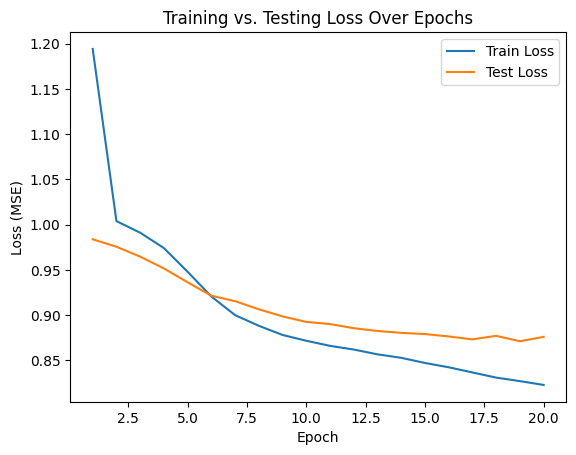

In [17]:
epochs = range(1, len(train_losses) + 1)
plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses,  label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training vs. Testing Loss Over Epochs')
plt.show()

In [29]:
from src.models.deep_learning.neural_net_autoencoder import TemporalAutoencoder
import torch.optim as optim  # Make sure this is imported

# 1) Select one series from train/test
train_key = next(iter(train_dict))
train_data = train_dict[7776]

# split at the break:
bp_train = int(len(train_data.period_0_values) * 0.7)

test_data = np.concatenate((train_data.period_0_values[bp_train:], train_data.period_1_values))

# 2) Prepare sliding windows
seq_len = 128
X_train_w = get_sliding_windows_from_sequence(train_data.period_0_values[:bp_train], seq_len)
X_test_w = get_sliding_windows_from_sequence(test_data, seq_len)

# 3) Scale by train std
scale = np.std(X_train_w) + 1e-8
X_train_s = X_train_w / scale
X_test_s  = X_test_w / scale

# 4) To torch
# 1) Convert once, up front, to one big GPU tensor
X_train = torch.from_numpy(X_train_s).float().to(device)  # shape [N_train, seq_len]
X_test  = torch.from_numpy(X_test_s).float().to(device)   # shape [N_test,  seq_len]

# 2) Model, loss, optimizer with learning rate decay
model     = TemporalAutoencoder(seq_len, bottleneck_dim=32, hidden_dims=[seq_len, seq_len//2, seq_len//2, seq_len//4]).to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-4)

# 3) Manual batching without DataLoader
batch_size  = 32
num_epochs  = 200
train_losses = []
test_losses  = []
N_train     = X_train.size(0)
N_test      = X_test.size(0)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-4)

for epoch in range(1, num_epochs+1):
    model.train()
    # — shuffle GPU indices once per epoch —
    perm = torch.randperm(N_train, device=device)
    epoch_train_loss = 0.0

    # — iterate in-GPU batches —
    for i in range(0, N_train, batch_size):
        batch_idx = perm[i:i+batch_size]
        batch      = X_train[batch_idx]  # already on GPU
        
        optimizer.zero_grad()
        recon = model(batch)
        loss  = criterion(recon, batch)
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item() * batch.size(0)
    epoch_train_loss /= N_train

    # — eval on test set similarly —
    model.eval()
    with torch.no_grad():
        recon = model(X_test)
        loss  = criterion(recon, X_test)
        epoch_test_loss = loss.item()

    train_losses.append(epoch_train_loss)
    test_losses.append(epoch_test_loss)
    
    # Step the learning rate scheduler
    scheduler.step()
    
    # Print with current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch:03d} — Train Loss: {epoch_train_loss:.6f}, Test Loss: {epoch_test_loss:.6f}, LR: {current_lr:.2e}")

Epoch 001 — Train Loss: 1.005313, Test Loss: 0.978221, LR: 1.00e-02
Epoch 002 — Train Loss: 1.001506, Test Loss: 0.978474, LR: 1.00e-02
Epoch 003 — Train Loss: 1.001146, Test Loss: 0.978184, LR: 9.99e-03
Epoch 004 — Train Loss: 1.000905, Test Loss: 0.978370, LR: 9.99e-03
Epoch 005 — Train Loss: 1.000926, Test Loss: 0.978201, LR: 9.98e-03
Epoch 006 — Train Loss: 1.000769, Test Loss: 0.978715, LR: 9.98e-03
Epoch 007 — Train Loss: 1.000722, Test Loss: 0.979143, LR: 9.97e-03
Epoch 008 — Train Loss: 1.000684, Test Loss: 0.979238, LR: 9.96e-03
Epoch 009 — Train Loss: 1.000657, Test Loss: 0.979189, LR: 9.95e-03
Epoch 010 — Train Loss: 1.000648, Test Loss: 0.979310, LR: 9.94e-03
Epoch 011 — Train Loss: 1.000705, Test Loss: 0.979448, LR: 9.93e-03
Epoch 012 — Train Loss: 1.000657, Test Loss: 0.979447, LR: 9.91e-03
Epoch 013 — Train Loss: 1.000662, Test Loss: 0.979382, LR: 9.90e-03
Epoch 014 — Train Loss: 1.000723, Test Loss: 0.979295, LR: 9.88e-03
Epoch 015 — Train Loss: 1.000787, Test Loss: 0.9

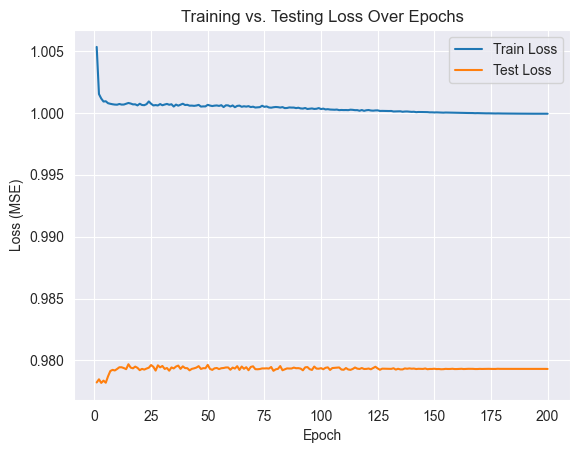

In [30]:
epochs = range(1, len(train_losses) + 1)
plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses,  label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training vs. Testing Loss Over Epochs')
plt.show()

In [69]:
# 1) Select one series from train/test
train_key = next(iter(train_dict))
train_data = train_dict[7776]

# split at the break:
bp_train = int(len(train_data.period_0_values) * 0.7)

test_data = np.concatenate((train_data.period_0_values[bp_train:], train_data.period_1_values))

# 2) Prepare sliding windows
seq_len = 128
X_train_w = get_sliding_windows_from_sequence(train_data.period_0_values[:bp_train], seq_len)
X_test_w = get_sliding_windows_from_sequence(test_data, seq_len)

# 3) Scale by train std
scale = np.std(X_train_w) + 1e-8
X_train_s = X_train_w / scale
X_test_s  = X_test_w / scale

# 4) To torch
# 1) Convert once, up front, to one big GPU tensor
X_train = torch.from_numpy(X_train_s).float().to(device)  # shape [N_train, seq_len]
X_test  = torch.from_numpy(X_test_s).float().to(device)   # shape [N_test,  seq_len]

# 2) Model, loss, optimizer
model     = TransformerTemporalAutoencoder(sequence_length=128, raise_dim=4, bottleneck_dim=32, dropout=0.2).to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-4)

# 3) Manual batching without DataLoader
batch_size  = 32
num_epochs  = 25
train_losses = []
test_losses  = []
N_train     = X_train.size(0)
N_test      = X_test.size(0)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

for epoch in range(1, num_epochs+1):
    model.train()
    # — shuffle GPU indices once per epoch —
    perm = torch.randperm(N_train, device=device)
    epoch_train_loss = 0.0

    # — iterate in-GPU batches —
    for i in range(0, N_train, batch_size):
        batch_idx = perm[i:i+batch_size]
        batch      = X_train[batch_idx].unsqueeze(-1)
        
        optimizer.zero_grad()
        recon = model.forward(batch)
        loss  = criterion(recon, batch.squeeze())
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item() * batch.size(0)
    epoch_train_loss /= N_train
    
    scheduler.step()

    # — eval on test set similarly —
    model.eval()
    with torch.no_grad():
        recon = model.forward(X_test.clone().unsqueeze(-1))
        loss  = criterion(recon, X_test)
        epoch_test_loss = loss.item()
        
    train_losses.append(epoch_train_loss)
    test_losses.append(epoch_test_loss)
    print(f"Epoch {epoch:03d} — Train Loss: {epoch_train_loss:.6f}, Test Loss: {epoch_test_loss:.6f}")

Epoch 001 — Train Loss: 1.087198, Test Loss: 1.022672
Epoch 002 — Train Loss: 1.002260, Test Loss: 0.978800
Epoch 003 — Train Loss: 1.000962, Test Loss: 0.982151
Epoch 004 — Train Loss: 1.000779, Test Loss: 0.982173
Epoch 005 — Train Loss: 1.000287, Test Loss: 0.980440
Epoch 006 — Train Loss: 1.000275, Test Loss: 0.979822
Epoch 007 — Train Loss: 1.000308, Test Loss: 0.980259
Epoch 008 — Train Loss: 1.000389, Test Loss: 0.979024
Epoch 009 — Train Loss: 1.000303, Test Loss: 0.980184
Epoch 010 — Train Loss: 1.000131, Test Loss: 0.979493
Epoch 011 — Train Loss: 1.000328, Test Loss: 0.978901
Epoch 012 — Train Loss: 1.000158, Test Loss: 0.980592
Epoch 013 — Train Loss: 0.999277, Test Loss: 0.977149
Epoch 014 — Train Loss: 0.988141, Test Loss: 0.947452
Epoch 015 — Train Loss: 0.945304, Test Loss: 0.904741
Epoch 016 — Train Loss: 0.889168, Test Loss: 0.856360
Epoch 017 — Train Loss: 0.849332, Test Loss: 0.831267
Epoch 018 — Train Loss: 0.818739, Test Loss: 0.817757
Epoch 019 — Train Loss: 0.79

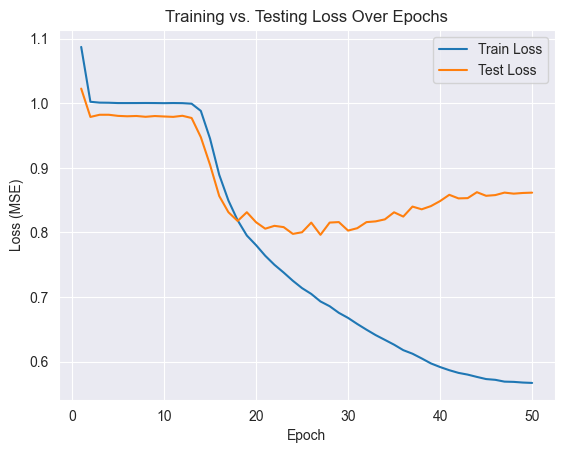

In [70]:
epochs = range(1, len(train_losses) + 1)
plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses,  label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training vs. Testing Loss Over Epochs')
plt.show()

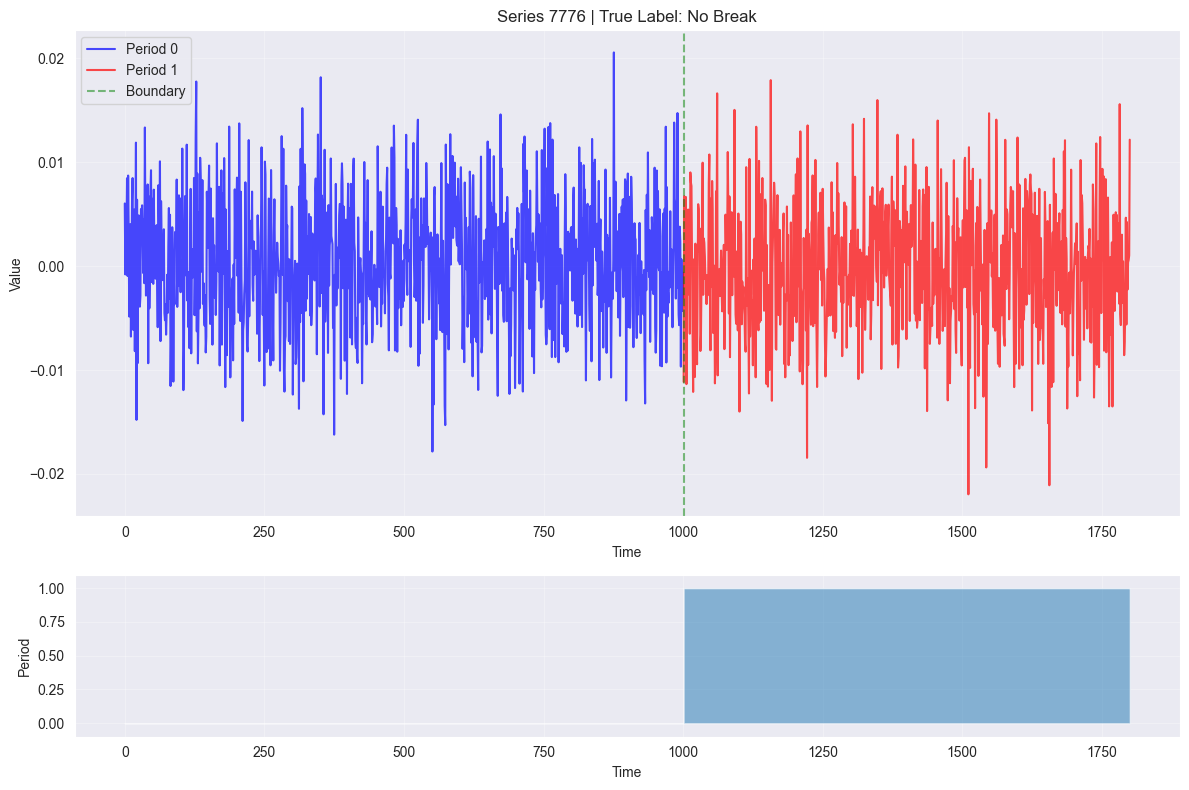

In [71]:
plot_timeseries_dataclass(train_dict[7776])

In [72]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy import stats
from scipy.fft import fft, fftfreq
from typing import Dict, Tuple
import warnings


class TransformerBreakDetectionExtractor:
    """
    Transformer-based autoencoder feature extractor for break detection
    Uses optimized hyperparameters and comprehensive feature extraction
    """

    def __init__(self, sequence_length: int = 128, train_ratio: float = 0.7):
        self.sequence_length = sequence_length
        self.train_ratio = train_ratio
        self.autoencoder = None
        self.scale_factor = 1.0
        self.training_losses = []

    def train_autoencoder_on_regime(self, regime_data: np.ndarray,
                                    raise_dim: int = 4,
                                    bottleneck_dim: int = 32,
                                    dropout: float = 0.2,
                                    num_epochs: int = 25) -> Dict:
        """Train transformer autoencoder on a specific regime with optimal parameters"""
        
        # Create sliding windows
        sequences = get_sliding_windows_from_sequence(regime_data, self.sequence_length)

        # Scale by standard deviation (matching your approach)
        scale_factor = np.std(sequences) + 1e-8
        sequences_scaled = sequences / scale_factor
        self.scale_factor = scale_factor

        # Create transformer autoencoder with optimal parameters
        self.autoencoder = TransformerTemporalAutoencoder(
            sequence_length=self.sequence_length,
            raise_dim=raise_dim,
            bottleneck_dim=bottleneck_dim,
            dropout=dropout
        ).to(device)

        # Training setup with optimal parameters
        criterion = nn.MSELoss(reduction='mean')
        optimizer = optim.Adam(self.autoencoder.parameters(), lr=1e-2, weight_decay=1e-4)

        # Convert to tensors
        X_train = torch.from_numpy(sequences_scaled).float().to(device)
        N_train = X_train.size(0)
        batch_size = 32

        # Learning rate scheduler
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

        # Training loop (matching your exact approach)
        self.autoencoder.train()
        train_losses = []

        for epoch in range(1, num_epochs + 1):
            # Shuffle GPU indices once per epoch
            perm = torch.randperm(N_train, device=device)
            epoch_train_loss = 0.0

            # Iterate in-GPU batches
            for i in range(0, N_train, batch_size):
                batch_idx = perm[i:i+batch_size]
                batch = X_train[batch_idx].unsqueeze(-1)  # Add channel dimension

                optimizer.zero_grad()
                recon = self.autoencoder.forward(batch)
                loss = criterion(recon, batch.squeeze())
                loss.backward()
                optimizer.step()

                epoch_train_loss += loss.item() * batch.size(0)

            epoch_train_loss /= N_train
            scheduler.step()
            train_losses.append(epoch_train_loss)

        self.training_losses = train_losses

        return {
            'final_loss': train_losses[-1],
            'n_sequences': len(sequences),
            'convergence_rate': self._calculate_convergence_rate(train_losses)
        }

    def get_reconstruction_data(self, time_series: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """Get reconstruction errors, correlations, and residuals for a time series"""
        if self.autoencoder is None:
            raise ValueError("Autoencoder not trained yet")

        sequences = get_sliding_windows_from_sequence(time_series, self.sequence_length)
        sequences_scaled = sequences / self.scale_factor

        self.autoencoder.eval()
        with torch.no_grad():
            X_tensor = torch.from_numpy(sequences_scaled).float().to(device)
            X_input = X_tensor.unsqueeze(-1)  # Add channel dimension
            reconstructed = self.autoencoder(X_input).cpu().numpy()

        # Calculate various metrics
        # 1. MSE per sequence (reconstruction errors)
        reconstruction_errors = np.mean((sequences_scaled - reconstructed) ** 2, axis=1)

        # 2. Pearson correlations per sequence
        correlations = []
        for i in range(len(sequences_scaled)):
            corr, _ = stats.pearsonr(sequences_scaled[i], reconstructed[i])
            correlations.append(corr if not np.isnan(corr) else 0.0)
        correlations = np.array(correlations)

        # 3. Residuals (raw differences)
        residuals = sequences_scaled - reconstructed

        return reconstruction_errors, correlations, residuals

    def extract_break_detection_features(self, time_series: np.ndarray,
                                         break_point: int) -> Dict[str, float]:
        """
        Extract comprehensive features for break detection
        """
        features = {}

        try:
            # Split at known break point
            regime1 = time_series[:break_point]
            regime2 = time_series[break_point:]

            # Train on partial regime 1 (first 70%)
            train_size = int(self.train_ratio * len(regime1))
            train_data = regime1[:train_size]

            # Train autoencoder
            training_info = self.train_autoencoder_on_regime(train_data)
            features.update(self._extract_training_features(training_info))

            # Get reconstruction data for different parts
            regime1_holdout = regime1[train_size:]
            errors_r1, corrs_r1, residuals_r1 = self.get_reconstruction_data(regime1_holdout)
            errors_r2, corrs_r2, residuals_r2 = self.get_reconstruction_data(regime2)

            # Extract features from each category
            features.update(self._extract_error_features(errors_r1, errors_r2))
            features.update(self._extract_correlation_features(corrs_r1, corrs_r2))
            features.update(self._extract_residual_features(residuals_r1, residuals_r2))
            features.update(self._extract_statistical_test_features(errors_r1, errors_r2, corrs_r1, corrs_r2))
            features.update(self._extract_distribution_features(residuals_r1, residuals_r2))
            features.update(self._extract_spectral_features(residuals_r1, residuals_r2))
            features.update(self._extract_temporal_features(regime1_holdout, regime2))

            # Transition region features
            transition_size = min(self.sequence_length * 2, len(regime1) // 4, len(regime2) // 4)
            transition_data = time_series[break_point - transition_size:break_point + transition_size]
            errors_trans, corrs_trans, residuals_trans = self.get_reconstruction_data(transition_data)
            features.update(self._extract_transition_features(errors_trans, corrs_trans, errors_r1))

        except Exception as e:
            print(f"Feature extraction failed: {e}")
            return self._get_default_features()

        return features

    def _extract_training_features(self, training_info: Dict) -> Dict[str, float]:
        """Extract features from training process"""
        return {
            'ae_final_training_loss': training_info['final_loss'],
            'ae_convergence_rate': training_info['convergence_rate'],
            'ae_training_stability': np.std(self.training_losses[-5:]) if len(self.training_losses) >= 5 else 0.0
        }

    def _extract_error_features(self, errors_r1: np.ndarray, errors_r2: np.ndarray) -> Dict[str, float]:
        """Extract reconstruction error-based features"""
        mean_error_r1 = np.mean(errors_r1)
        mean_error_r2 = np.mean(errors_r2)
        
        return {
            'error_ratio_r2_r1': mean_error_r2 / (mean_error_r1 + 1e-8),
            'error_diff_r2_r1': mean_error_r2 - mean_error_r1,
            'error_var_ratio': np.var(errors_r2) / (np.var(errors_r1) + 1e-8),
            'error_std_ratio': np.std(errors_r2) / (np.std(errors_r1) + 1e-8),
            'error_r1_mean': mean_error_r1,
            'error_r2_mean': mean_error_r2,
            'error_r1_median': np.median(errors_r1),
            'error_r2_median': np.median(errors_r2),
            'error_percentile_75_ratio': np.percentile(errors_r2, 75) / (np.percentile(errors_r1, 75) + 1e-8),
            'error_percentile_95_ratio': np.percentile(errors_r2, 95) / (np.percentile(errors_r1, 95) + 1e-8),
            'error_max_ratio': np.max(errors_r2) / (np.max(errors_r1) + 1e-8),
        }

    def _extract_correlation_features(self, corrs_r1: np.ndarray, corrs_r2: np.ndarray) -> Dict[str, float]:
        """Extract correlation-based features"""
        mean_corr_r1 = np.mean(corrs_r1)
        mean_corr_r2 = np.mean(corrs_r2)
        
        return {
            'corr_mean_r1': mean_corr_r1,
            'corr_mean_r2': mean_corr_r2,
            'corr_diff_r2_r1': mean_corr_r2 - mean_corr_r1,
            'corr_ratio_r2_r1': mean_corr_r2 / (mean_corr_r1 + 1e-8),
            'corr_var_ratio': np.var(corrs_r2) / (np.var(corrs_r1) + 1e-8),
            'corr_min_r1': np.min(corrs_r1),
            'corr_min_r2': np.min(corrs_r2),
            'corr_std_r1': np.std(corrs_r1),
            'corr_std_r2': np.std(corrs_r2),
            'corr_median_diff': np.median(corrs_r2) - np.median(corrs_r1),
        }

    def _extract_residual_features(self, residuals_r1: np.ndarray, residuals_r2: np.ndarray) -> Dict[str, float]:
        """Extract features from raw residuals"""
        # Flatten residuals for analysis
        res_r1_flat = residuals_r1.flatten()
        res_r2_flat = residuals_r2.flatten()
        
        features = {}
        
        # Moments
        features['residual_mean_r1'] = np.mean(res_r1_flat)
        features['residual_mean_r2'] = np.mean(res_r2_flat)
        features['residual_std_r1'] = np.std(res_r1_flat)
        features['residual_std_r2'] = np.std(res_r2_flat)
        features['residual_skew_r1'] = stats.skew(res_r1_flat)
        features['residual_skew_r2'] = stats.skew(res_r2_flat)
        features['residual_kurtosis_r1'] = stats.kurtosis(res_r1_flat)
        features['residual_kurtosis_r2'] = stats.kurtosis(res_r2_flat)
        
        # Ratios
        features['residual_std_ratio'] = features['residual_std_r2'] / (features['residual_std_r1'] + 1e-8)
        features['residual_mean_diff'] = features['residual_mean_r2'] - features['residual_mean_r1']
        
        return features

    def _extract_statistical_test_features(self, errors_r1: np.ndarray, errors_r2: np.ndarray,
                                           corrs_r1: np.ndarray, corrs_r2: np.ndarray) -> Dict[str, float]:
        """Extract features from statistical tests"""
        features = {}
        
        if len(errors_r1) > 1 and len(errors_r2) > 1:
            # Tests on reconstruction errors
            _, features['error_mannwhitney_pvalue'] = stats.mannwhitneyu(errors_r1, errors_r2, alternative='two-sided')
            _, features['error_ks_pvalue'] = stats.ks_2samp(errors_r1, errors_r2)
            
            # t-test assuming unequal variances
            _, features['error_ttest_pvalue'] = stats.ttest_ind(errors_r1, errors_r2, equal_var=False)
            
            # Tests on correlations
            _, features['corr_mannwhitney_pvalue'] = stats.mannwhitneyu(corrs_r1, corrs_r2, alternative='two-sided')
            _, features['corr_ks_pvalue'] = stats.ks_2samp(corrs_r1, corrs_r2)
            _, features['corr_ttest_pvalue'] = stats.ttest_ind(corrs_r1, corrs_r2, equal_var=False)
            
        else:
            # Default values when not enough data
            for key in ['error_mannwhitney_pvalue', 'error_ks_pvalue', 'error_ttest_pvalue',
                       'corr_mannwhitney_pvalue', 'corr_ks_pvalue', 'corr_ttest_pvalue']:
                features[key] = 1.0
                
        return features

    def _extract_distribution_features(self, residuals_r1: np.ndarray, residuals_r2: np.ndarray) -> Dict[str, float]:
        """Extract features comparing residual distributions"""
        res_r1_flat = residuals_r1.flatten()
        res_r2_flat = residuals_r2.flatten()
        
        features = {}
        
        # Normality tests
        try:
            _, features['residual_shapiro_pvalue_r1'] = stats.shapiro(res_r1_flat[:5000])  # Limit for shapiro
            _, features['residual_shapiro_pvalue_r2'] = stats.shapiro(res_r2_flat[:5000])
        except:
            features['residual_shapiro_pvalue_r1'] = 1.0
            features['residual_shapiro_pvalue_r2'] = 1.0
            
        # Jarque-Bera test for normality
        try:
            _, features['residual_jarque_bera_pvalue_r1'] = stats.jarque_bera(res_r1_flat)
            _, features['residual_jarque_bera_pvalue_r2'] = stats.jarque_bera(res_r2_flat)
        except:
            features['residual_jarque_bera_pvalue_r1'] = 1.0
            features['residual_jarque_bera_pvalue_r2'] = 1.0
            
        # Anderson-Darling test
        try:
            ad_r1 = stats.anderson(res_r1_flat, dist='norm')
            ad_r2 = stats.anderson(res_r2_flat, dist='norm')
            features['residual_anderson_stat_r1'] = ad_r1.statistic
            features['residual_anderson_stat_r2'] = ad_r2.statistic
        except:
            features['residual_anderson_stat_r1'] = 0.0
            features['residual_anderson_stat_r2'] = 0.0
            
        return features

    def _extract_spectral_features(self, residuals_r1: np.ndarray, residuals_r2: np.ndarray) -> Dict[str, float]:
        """Extract frequency domain features from residuals"""
        features = {}
        
        try:
            # Average FFT across sequences
            fft_r1 = np.mean([np.abs(fft(seq)) for seq in residuals_r1], axis=0)
            fft_r2 = np.mean([np.abs(fft(seq)) for seq in residuals_r2], axis=0)
            
            # Energy in different frequency bands
            n = len(fft_r1)
            low_freq = n // 8
            mid_freq = n // 4
            high_freq = n // 2
            
            features['spectral_energy_low_r1'] = np.sum(fft_r1[:low_freq])
            features['spectral_energy_mid_r1'] = np.sum(fft_r1[low_freq:mid_freq])
            features['spectral_energy_high_r1'] = np.sum(fft_r1[mid_freq:high_freq])
            
            features['spectral_energy_low_r2'] = np.sum(fft_r2[:low_freq])
            features['spectral_energy_mid_r2'] = np.sum(fft_r2[low_freq:mid_freq])
            features['spectral_energy_high_r2'] = np.sum(fft_r2[mid_freq:high_freq])
            
            # Ratios
            total_energy_r1 = np.sum(fft_r1)
            total_energy_r2 = np.sum(fft_r2)
            
            features['spectral_energy_ratio'] = total_energy_r2 / (total_energy_r1 + 1e-8)
            features['spectral_centroid_r1'] = np.sum(np.arange(n) * fft_r1) / (total_energy_r1 + 1e-8)
            features['spectral_centroid_r2'] = np.sum(np.arange(n) * fft_r2) / (total_energy_r2 + 1e-8)
            
        except Exception as e:
            # Default spectral features
            for key in ['spectral_energy_low_r1', 'spectral_energy_mid_r1', 'spectral_energy_high_r1',
                       'spectral_energy_low_r2', 'spectral_energy_mid_r2', 'spectral_energy_high_r2',
                       'spectral_energy_ratio', 'spectral_centroid_r1', 'spectral_centroid_r2']:
                features[key] = 0.0
                
        return features

    def _extract_temporal_features(self, regime1: np.ndarray, regime2: np.ndarray) -> Dict[str, float]:
        """Extract temporal and autocorrelation features"""
        features = {}
        
        try:
            # Autocorrelation at different lags
            max_lag = min(20, len(regime1) // 4, len(regime2) // 4)
            
            if max_lag > 1:
                # Calculate autocorrelation
                def autocorr(x, max_lag):
                    x = x - np.mean(x)
                    autocorrs = []
                    for lag in range(1, max_lag + 1):
                        if len(x) > lag:
                            corr = np.corrcoef(x[:-lag], x[lag:])[0, 1]
                            autocorrs.append(corr if not np.isnan(corr) else 0.0)
                        else:
                            autocorrs.append(0.0)
                    return np.array(autocorrs)
                
                autocorr_r1 = autocorr(regime1, max_lag)
                autocorr_r2 = autocorr(regime2, max_lag)
                
                features['autocorr_lag1_r1'] = autocorr_r1[0] if len(autocorr_r1) > 0 else 0.0
                features['autocorr_lag1_r2'] = autocorr_r2[0] if len(autocorr_r2) > 0 else 0.0
                features['autocorr_mean_r1'] = np.mean(autocorr_r1)
                features['autocorr_mean_r2'] = np.mean(autocorr_r2)
                features['autocorr_diff'] = features['autocorr_mean_r2'] - features['autocorr_mean_r1']
                
                # Cross-correlation between regimes
                if len(regime1) > 0 and len(regime2) > 0:
                    min_len = min(len(regime1), len(regime2))
                    cross_corr = np.corrcoef(regime1[:min_len], regime2[:min_len])[0, 1]
                    features['cross_correlation'] = cross_corr if not np.isnan(cross_corr) else 0.0
                else:
                    features['cross_correlation'] = 0.0
            else:
                # Default values
                for key in ['autocorr_lag1_r1', 'autocorr_lag1_r2', 'autocorr_mean_r1',
                           'autocorr_mean_r2', 'autocorr_diff', 'cross_correlation']:
                    features[key] = 0.0
                    
        except Exception as e:
            # Default values on error
            for key in ['autocorr_lag1_r1', 'autocorr_lag1_r2', 'autocorr_mean_r1',
                       'autocorr_mean_r2', 'autocorr_diff', 'cross_correlation']:
                features[key] = 0.0
                
        return features

    def _extract_transition_features(self, errors_trans: np.ndarray, corrs_trans: np.ndarray,
                                     errors_r1: np.ndarray) -> Dict[str, float]:
        """Extract features from transition region"""
        mean_error_r1 = np.mean(errors_r1)
        
        return {
            'transition_error_spike': np.mean(errors_trans) / (mean_error_r1 + 1e-8),
            'transition_error_max': np.max(errors_trans) / (mean_error_r1 + 1e-8),
            'transition_corr_min': np.min(corrs_trans),
            'transition_corr_mean': np.mean(corrs_trans),
            'transition_error_var': np.var(errors_trans) / (np.var(errors_r1) + 1e-8),
        }

    def _calculate_convergence_rate(self, losses: list) -> float:
        """Calculate convergence rate from training losses"""
        if len(losses) < 5:
            return 0.0
        
        # Fit exponential decay to losses
        x = np.arange(len(losses))
        y = np.array(losses)
        
        try:
            # Avoid log of negative numbers
            y_positive = np.maximum(y, 1e-8)
            log_y = np.log(y_positive)
            slope = np.polyfit(x, log_y, 1)[0]
            return -slope  # Negative slope means convergence
        except:
            return 0.0

    def _get_default_features(self) -> Dict[str, float]:
        """Return default features when extraction fails"""
        default_features = {}
        
        # All feature categories with default values
        feature_names = [
            'ae_final_training_loss', 'ae_convergence_rate', 'ae_training_stability',
            'error_ratio_r2_r1', 'error_diff_r2_r1', 'error_var_ratio', 'error_std_ratio',
            'error_r1_mean', 'error_r2_mean', 'error_r1_median', 'error_r2_median',
            'error_percentile_75_ratio', 'error_percentile_95_ratio', 'error_max_ratio',
            'corr_mean_r1', 'corr_mean_r2', 'corr_diff_r2_r1', 'corr_ratio_r2_r1',
            'corr_var_ratio', 'corr_min_r1', 'corr_min_r2', 'corr_std_r1', 'corr_std_r2',
            'corr_median_diff', 'residual_mean_r1', 'residual_mean_r2', 'residual_std_r1',
            'residual_std_r2', 'residual_skew_r1', 'residual_skew_r2', 'residual_kurtosis_r1',
            'residual_kurtosis_r2', 'residual_std_ratio', 'residual_mean_diff',
            'error_mannwhitney_pvalue', 'error_ks_pvalue', 'error_ttest_pvalue',
            'corr_mannwhitney_pvalue', 'corr_ks_pvalue', 'corr_ttest_pvalue',
            'transition_error_spike', 'transition_error_max', 'transition_corr_min',
            'transition_corr_mean', 'transition_error_var'
        ]
        
        for name in feature_names:
            if 'pvalue' in name:
                default_features[name] = 1.0
            elif 'ratio' in name:
                default_features[name] = 1.0
            else:
                default_features[name] = 0.0
                
        return default_features


# Usage example:
def extract_features_for_series(series_id, train_dict):
    """Example of how to use the feature extractor"""
    
    # Get time series data
    train_data = train_dict[series_id]
    full_series = np.concatenate([train_data.period_0_values, train_data.period_1_values])
    break_point = len(train_data.period_0_values)
    
    # Create extractor
    extractor = TransformerBreakDetectionExtractor(sequence_length=128, train_ratio=0.7)
    
    # Extract features
    features = extractor.extract_break_detection_features(full_series, break_point)
    
    return features

# Example for multiple series:
def extract_features_for_dataset(train_dict, max_series=None):
    """Extract features for multiple time series"""
    import pandas as pd
    
    all_features = []
    series_ids = list(train_dict.keys())
    
    if max_series:
        series_ids = series_ids[:max_series]
    
    for i, series_id in enumerate(series_ids):
        print(f"Processing series {i+1}/{len(series_ids)}: {series_id}")
        
        try:
            features = extract_features_for_series(series_id, train_dict)
            features['series_id'] = series_id
            all_features.append(features)
        except Exception as e:
            print(f"Failed to process series {series_id}: {e}")
    
    return pd.DataFrame(all_features)

# Example usage:
# features_df = extract_features_for_dataset(train_dict, max_series=100)
# print(f"Extracted {len(features_df)} feature sets with {len(features_df.columns)} features each")

In [73]:
features_df = extract_features_for_dataset(train_dict, max_series=100)
print(f"Extracted {len(features_df)} feature sets with {len(features_df.columns)} features each")

Processing series 1/100: 2093
Processing series 2/100: 2543
Processing series 3/100: 8455
Processing series 4/100: 875
Processing series 5/100: 2146
Processing series 6/100: 123
Processing series 7/100: 8093
Processing series 8/100: 6771
Processing series 9/100: 5903
Processing series 10/100: 1026
Processing series 11/100: 1143
Processing series 12/100: 3570
Processing series 13/100: 4209
Processing series 14/100: 1486
Processing series 15/100: 9083
Processing series 16/100: 8336
Feature extraction failed: tuple index out of range
Processing series 17/100: 2114
Processing series 18/100: 1051
Processing series 19/100: 1609
Processing series 20/100: 5895
Processing series 21/100: 42
Processing series 22/100: 9246
Processing series 23/100: 3083
Processing series 24/100: 4470
Processing series 25/100: 8245
Processing series 26/100: 1797
Processing series 27/100: 7818
Processing series 28/100: 7849
Processing series 29/100: 4888
Processing series 30/100: 3565
Processing series 31/100: 1211


In [100]:
test_labels = pd.DataFrame(columns=['series_id', 'has_break'])

for v in test_dict.values():
    # len(test_labels) gives the next integer index
    test_labels.loc[len(test_labels)] = [v.series_id, v.has_break]
new_test_data = test_labels.set_index("series_id").join(test_features.set_index("series_id"))
new_test_data

,has_break,ae_final_training_loss,ae_convergence_rate,ae_training_stability,error_ratio_r2_r1,error_diff_r2_r1,error_var_ratio,error_std_ratio,error_r1_mean,error_r2_mean,...,autocorr_lag1_r2,autocorr_mean_r1,autocorr_mean_r2,autocorr_diff,cross_correlation,transition_error_spike,transition_error_max,transition_corr_min,transition_corr_mean,transition_error_var
series_id,,,,,,,,,,,,,,,,,,,,,
2900,False,0.616152,0.019021,0.002142,2.105860,0.499252,30.438401,5.517104,0.451460,0.950711,...,0.040122,-0.008651,0.003169,0.011820,0.004834,0.869202,1.708817,0.406906,0.549617,0.739891
752,False,0.667733,0.020112,0.006276,0.737541,-0.151926,4.402233,2.098150,0.578857,0.426931,...,0.017570,-0.022428,-0.012973,0.009455,0.010734,0.542138,1.219164,0.278852,0.404276,1.150093
7409,True,0.717343,0.017201,0.002249,2.899378,0.748570,178.082116,13.344760,0.394113,1.142683,...,-0.081527,-0.010023,-0.019382,-0.009359,0.001154,1.280924,2.245052,0.252876,0.480452,10.967587
6084,False,0.415518,0.040794,0.001870,0.911340,-0.046129,0.286316,0.535085,0.520292,0.474163,...,0.500411,0.042198,0.003532,-0.038666,0.060992,0.819239,1.149675,0.587598,0.700238,0.347898
1076,True,0.634968,0.017479,0.001625,1.158707,0.168593,1.152352,1.073477,1.062294,1.230887,...,0.118891,-0.017634,0.004698,0.022332,0.025986,1.537358,3.099720,0.355110,0.542524,1.272167
499,False,0.777850,0.012317,0.007209,1.279651,0.246255,0.093487,0.305756,0.880578,1.126833,...,-0.177909,-0.015431,-0.017435,-0.002005,-0.015437,2.237131,2.302475,0.370886,0.398070,0.008955
4878,False,0.651049,0.019276,0.005150,0.531462,-0.412348,1.118513,1.057598,0.880073,0.467726,...,0.013852,-0.014363,-0.010550,0.003813,-0.026799,0.789860,1.494220,0.369143,0.492547,0.593666
9055,False,0.592576,0.025052,0.006071,1.416664,0.186357,1.287424,1.134647,0.447260,0.633616,...,-0.001852,-0.012533,-0.002797,0.009736,-0.019061,0.371119,0.531416,0.317356,0.477635,0.004080
598,False,0.546431,0.028296,0.004238,0.926762,-0.040537,2.136903,1.461815,0.553493,0.512956,...,-0.044092,-0.003637,0.004243,0.007880,0.013680,0.902782,1.996072,0.220442,0.506831,1.183650


In [91]:
train_labels = pd.DataFrame(columns=['series_id', 'has_break'])

for v in train_dict.values():
    train_labels.loc[len(train_labels)] = [v.series_id, v.has_break]
new_train_data = train_labels.set_index("series_id").join(features_df.set_index("series_id"))
new_train_data

,has_break,ae_final_training_loss,ae_convergence_rate,ae_training_stability,error_ratio_r2_r1,error_diff_r2_r1,error_var_ratio,error_std_ratio,error_r1_mean,error_r2_mean,...,autocorr_lag1_r2,autocorr_mean_r1,autocorr_mean_r2,autocorr_diff,cross_correlation,transition_error_spike,transition_error_max,transition_corr_min,transition_corr_mean,transition_error_var
series_id,,,,,,,,,,,,,,,,,,,,,
2093,False,0.527477,0.028410,0.003554,0.319828,-0.844544,0.078467,0.280119,1.241662,0.397118,...,-0.154279,-0.008998,-0.008880,0.000118,-0.010086,0.917076,1.472201,0.315417,0.448994,0.588019
2543,False,0.653688,0.018888,0.002627,0.945848,-0.021660,0.722378,0.849929,0.399994,0.378334,...,0.045400,0.000748,0.032227,0.031479,-0.026820,1.137700,1.546330,0.439448,0.522671,0.894905
8455,True,0.600390,0.023142,0.003893,2.235364,0.452644,78.119440,8.838533,0.366405,0.819049,...,-0.053222,-0.011035,0.003664,0.014698,-0.001163,1.330407,1.521820,0.366701,0.461392,0.261109
875,False,0.734303,0.017564,0.001035,1.065417,0.046216,0.435079,0.659605,0.706489,0.752705,...,-0.016308,0.005936,-0.001292,-0.007228,0.034962,1.105473,1.348157,0.389080,0.485924,0.319916
2146,False,0.665763,0.022680,0.004520,1.565874,0.238620,27.210161,5.216343,0.421683,0.660303,...,-0.130232,0.002385,-0.010797,-0.013182,0.014837,1.528713,1.982936,0.368202,0.437678,2.836157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4079,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5981,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9788,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [101]:
new_data = pd.concat([new_train_data, new_test_data], axis=1)

In [102]:
X, y = new_data.drop("has_break", axis=1), new_data["has_break"]

In [131]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_validate, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, roc_auc_score

# 1) Prepare X, y
new_data = new_data.loc[:, ~new_data.columns.duplicated()]

X = new_data.drop("has_break", axis=1).fillna(0)
y = new_data["has_break"].fillna(True).copy()   # now a single Series

# 2) Define the XGBoost classifier
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    objective='binary:logistic',
    random_state=42,
    n_jobs=-1
)

# 3) Set up the scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'roc_auc': make_scorer(roc_auc_score)
}

# 4) Stratified K-Fold for balanced splits
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 5) Run cross-validation
cv_results = cross_validate(
    estimator=xgb_model,
    X=X,
    y=y,
    scoring=scoring,
    cv=cv,
    return_train_score=True,
    return_estimator=True,
)

# 6) Summarize the CV scores
summary = []
for metric in scoring:
    summary.append({
        'metric': metric,
        'train_mean': np.mean(cv_results[f'train_{metric}']),
        'train_std':  np.std(cv_results[f'train_{metric}']),
        'test_mean':  np.mean(cv_results[f'test_{metric}']),
        'test_std':   np.std(cv_results[f'test_{metric}']),
    })

cv_summary = pd.DataFrame(summary).set_index('metric')
print("=== Cross-Validation Summary ===")
print(cv_summary.round(4))

# 7) Aggregate feature importances across folds
feature_names = X.columns.tolist()
importances = np.vstack([est.feature_importances_ for est in cv_results['estimator']])
mean_importances = importances.mean(axis=0)

feat_imp_df = (
    pd.DataFrame({
        'feature': feature_names,
        'mean_importance': mean_importances
    })
    .sort_values('mean_importance', ascending=False)
)

roc_auc_test_mean = cv_summary.loc['roc_auc', 'test_mean']
roc_auc_test_std  = cv_summary.loc['roc_auc', 'test_std']

print(f"Cross-validated ROC-AUC: {roc_auc_test_mean:.4f} ± {roc_auc_test_std:.4f}")

print("\n=== Top 10 Features by Mean Importance ===")
print(feat_imp_df.head(10))


C:\Users\StefanConstantin\AppData\Local\Temp\ipykernel_26924\580855597.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = new_data["has_break"].fillna(True).copy()   # now a single Series


=== Cross-Validation Summary ===
           train_mean  train_std  test_mean  test_std
metric                                               
accuracy       0.7789     0.0198     0.5421    0.1053
precision      0.6621     0.0192     0.4907    0.0836
recall         1.0000     0.0000     0.6752    0.0657
roc_auc        0.8053     0.0179     0.5581    0.0958
Cross-validated ROC-AUC: 0.5581 ± 0.0958

=== Top 10 Features by Mean Importance ===
                       feature  mean_importance
52       spectral_energy_ratio         0.058950
61      transition_error_spike         0.048688
60           cross_correlation         0.028359
15                corr_mean_r2         0.026875
41  residual_shapiro_pvalue_r2         0.026840
50      spectral_energy_mid_r2         0.026045
45   residual_anderson_stat_r2         0.024559
8                error_r2_mean         0.023880
39           corr_ttest_pvalue         0.022484
58            autocorr_mean_r2         0.021526


In [138]:
ids = new_data.index.tolist()

In [139]:
from src.features.extract_autocorrelation_features import AutocorrelationFeatureExtractor
from src.features.extract_changepoint_features import ChangepointFeatureExtractor
from src.features.extract_cusum_breakpoint_features import CusumBreakpointFeatureExtractor
from src.features.extract_factor_break_features import FactorBreakFeatureExtractor

import numpy as np
import pandas as pd

import logging

from src.data.dataLoader import StructuralBreakDataLoader
from src.features.extract_information_features import InformationFeatureExtractor
from src.features.extract_regression_breakpoint_features import RegressionBreakpointFeatureExtractor
from src.features.extract_rolling_features import RollingFeatureExtractor
from src.features.extract_spectral_features import SpectralFeatureExtractor
from src.features.extract_volatility_features import VolatilityFeatureExtractor
from src.features.extract_distribution_features import DistributionCombinedFeatureExtractor
    

In [140]:
volatilityExtractor = VolatilityFeatureExtractor()
spectralExtractor = SpectralFeatureExtractor()
rollingExtractor = RollingFeatureExtractor()
regressionBreakpointExtractor = RegressionBreakpointFeatureExtractor()
informationExtractor = InformationFeatureExtractor()
factorBreakExtractor = FactorBreakFeatureExtractor()
cusumBreakpointExtractor = CusumBreakpointFeatureExtractor()
changepointExtractor = ChangepointFeatureExtractor()
autocorrelationExtractor = AutocorrelationFeatureExtractor()
distributionCombinedExtractor = DistributionCombinedFeatureExtractor()

Loaded cache from C:\Users\StefanConstantin\Documents\Git\Python\ADIA Lab Structural Break Challenge\.cache\volatility_features.parquet with 10000 entries
Loaded cache from C:\Users\StefanConstantin\Documents\Git\Python\ADIA Lab Structural Break Challenge\.cache\spectral_features.parquet with 10000 entries
Loaded cache from C:\Users\StefanConstantin\Documents\Git\Python\ADIA Lab Structural Break Challenge\.cache\rolling_features.parquet with 10000 entries
Loaded cache from C:\Users\StefanConstantin\Documents\Git\Python\ADIA Lab Structural Break Challenge\.cache\regression_breakpoint_features.parquet with 10000 entries
Loaded cache from C:\Users\StefanConstantin\Documents\Git\Python\ADIA Lab Structural Break Challenge\.cache\information_features.parquet with 10000 entries
Loaded cache from C:\Users\StefanConstantin\Documents\Git\Python\ADIA Lab Structural Break Challenge\.cache\factor_break_features.parquet with 10000 entries
Loaded cache from C:\Users\StefanConstantin\Documents\Git\Pyt

C:\Users\StefanConstantin\Documents\Git\Python\ADIA Lab Structural Break Challenge\src\features\base_feature_extractor.py:72: UserWarning: Cache parameters don't match current parameters. Will recompute.
  warnings.warn("Cache parameters don't match current parameters. Will recompute.")


In [141]:
data_dict = train_dict | test_dict

In [143]:
feature_list = []
labels = []
series_ids = []

for series_id, ts_obj in data_dict.items():
    # 0.626
    volatility_features = volatilityExtractor.extract_features(ts_obj)

    # 0.582
    spectral_features = spectralExtractor.extract_features(ts_obj)

    # 0.6
    rolling_features = rollingExtractor.extract_features(ts_obj)

    # 0.618
    regression_breakpoint_features = regressionBreakpointExtractor.extract_features(ts_obj)

    # 0.544
    information_features = informationExtractor.extract_features(ts_obj)

    # 0.522
    factor_break_features = factorBreakExtractor.extract_features(ts_obj)

    # 0.64
    cusum_breakpoint_features = cusumBreakpointExtractor.extract_features(ts_obj)

    # 0.573
    changepoint_features = changepointExtractor.extract_features(ts_obj)

    # 0.517
    autocorrelation_features = autocorrelationExtractor.extract_features(ts_obj)

    # 0.69
    distribution_combined_features = distributionCombinedExtractor.extract_features(ts_obj)

    total_feats = (volatility_features | spectral_features | rolling_features | regression_breakpoint_features |
                   information_features | factor_break_features | cusum_breakpoint_features |
                   changepoint_features | autocorrelation_features | distribution_combined_features)

    if series_id % 100 == 0:
        print(f"Series {series_id}s")


    feature_list.append(total_feats)
    labels.append(ts_obj.has_break)
    series_ids.append(ts_obj.series_id)

if not feature_list:
    raise RuntimeError("No features extracted; check data and extraction functions.")

feature_df = pd.DataFrame(feature_list, index=series_ids)
label_series = pd.Series(labels, index=series_ids, name='has_break')

Value mismatch for p0_mi_lag1: cached=0.10764782275107354, computed=0.10765048732851223


C:\Users\StefanConstantin\Documents\Git\Python\ADIA Lab Structural Break Challenge\src\features\base_feature_extractor.py:274: UserWarning: Cache verification failed! Deleting cache and recomputing...
  warnings.warn("Cache verification failed! Deleting cache and recomputing...")


Series 7400s
Saved cache to C:\Users\StefanConstantin\Documents\Git\Python\ADIA Lab Structural Break Challenge\.cache\information_features.parquet with 100 entries
Saved cache to C:\Users\StefanConstantin\Documents\Git\Python\ADIA Lab Structural Break Challenge\.cache\cusum_breakpoint_features.parquet with 100 entries
Series 2200s
Series 2900s


In [144]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_validate, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, roc_auc_score

# 1) Prepare X, y
new_data = new_data.loc[:, ~new_data.columns.duplicated()]

X = feature_df
y = label_series

# 2) Define the XGBoost classifier
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    objective='binary:logistic',
    random_state=42,
    n_jobs=-1
)

# 3) Set up the scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'roc_auc': make_scorer(roc_auc_score)
}

# 4) Stratified K-Fold for balanced splits
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 5) Run cross-validation
cv_results = cross_validate(
    estimator=xgb_model,
    X=X,
    y=y,
    scoring=scoring,
    cv=cv,
    return_train_score=True,
    return_estimator=True,
)

# 6) Summarize the CV scores
summary = []
for metric in scoring:
    summary.append({
        'metric': metric,
        'train_mean': np.mean(cv_results[f'train_{metric}']),
        'train_std':  np.std(cv_results[f'train_{metric}']),
        'test_mean':  np.mean(cv_results[f'test_{metric}']),
        'test_std':   np.std(cv_results[f'test_{metric}']),
    })

cv_summary = pd.DataFrame(summary).set_index('metric')
print("=== Cross-Validation Summary ===")
print(cv_summary.round(4))

# 7) Aggregate feature importances across folds
feature_names = X.columns.tolist()
importances = np.vstack([est.feature_importances_ for est in cv_results['estimator']])
mean_importances = importances.mean(axis=0)

feat_imp_df = (
    pd.DataFrame({
        'feature': feature_names,
        'mean_importance': mean_importances
    })
    .sort_values('mean_importance', ascending=False)
)

roc_auc_test_mean = cv_summary.loc['roc_auc', 'test_mean']
roc_auc_test_std  = cv_summary.loc['roc_auc', 'test_std']

print(f"Cross-validated ROC-AUC: {roc_auc_test_mean:.4f} ± {roc_auc_test_std:.4f}")

print("\n=== Top 10 Features by Mean Importance ===")
print(feat_imp_df.head(10))


=== Cross-Validation Summary ===
           train_mean  train_std  test_mean  test_std
metric                                               
accuracy          1.0        0.0     0.6686    0.0588
precision         1.0        0.0     0.4117    0.1082
recall            1.0        0.0     0.2076    0.0448
roc_auc           1.0        0.0     0.5326    0.0383
Cross-validated ROC-AUC: 0.5326 ± 0.0383

=== Top 10 Features by Mean Importance ===
                   feature  mean_importance
142       diff_acf_sum_abs         0.018486
167            levene_stat         0.017734
28      dominant_freq_diff         0.017170
20   p0_spectral_bandwidth         0.017093
105         cusumsq_pvalue         0.015715
41                rss_post         0.014399
34       rolling_std_ratio         0.013355
37                  n_full         0.013002
51              p0_mi_lag1         0.012781
24   p1_spectral_bandwidth         0.012582
